# TD de machine Learning : Catégorisation musicale

**Elective** : Machine Learning   
**Professeur** : Théophile Ravillion   
**Date** : Vendredi 23 Avril 2021

## Contexte 
Vous travaillez chez Deezer, département Data Science, félicitations.
D'habiles ingénieurs musicologues ont mis au point un jeu de données contenant des informations sur des morceaux de musique. 
Avec quelques transformées de Fourier et autres joyeusetés propres à leur art, ils ont mis au point deux jeux de données contenant de nombreux indicateurs décrivant un morceau de musique.
Ils comptent sur vous pour mettre au point un algorithme capable d'identifier le genre musical d'un morceau sur la base des différents indicateurs qu'ils ont mis au point.
Vous vous apprétiez à leur demander des informations concernant ces variables mais vous constatez qu'ils sont partis en séminaire d'entreprise et que vous vous retrouvez tout seul avec un jeu d'entrainement étiqueté, un jeu de test et un post-it goguenard de votre chef qui vous demande de faire des prédictions précises sur le jeu de test d'ici 16h.

## Votre défi :
Modéliser le problème, construire un modèle et faire une prédiction de la catégorie à laquelle appartient chaque élément du fichier test.csv à l'aide d'un modèle aussi simple et performant que possible.


## Livrable
Un projet github contenant un notebook + un fichier prédictions.csv contenant les prédictions faites sur le jeu de test

En header le nom des colonnes (music_id et prediction) et pour chacun des morceaux la catégorie prédite.
Merci d'utiliser la virgule comme séparateur 

Bonne chance !

# Feuille de route

Comment procéder ? 
Pour réaliser cet exercice, il vous faudra :

## Récuperer les données 

In [1]:
!pip install lightgbm
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Lasso, LogisticRegression
from sklearn.feature_selection import SelectFromModel
from sklearn.preprocessing import StandardScaler
import numpy as np
from sklearn.impute import KNNImputer
from lightgbm import LGBMClassifier
from sklearn.metrics import mean_absolute_error, accuracy_score
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("whitegrid")
import warnings
warnings.filterwarnings('ignore')

url_train = "https://raw.githubusercontent.com/RTheophile/td_ml_ynov/main/data/train.csv"
url_test = "https://raw.githubusercontent.com/RTheophile/td_ml_ynov/main/data/test.csv"

df_train = pd.read_csv(url_train, sep=',', decimal='.' )
df_test = pd.read_csv(url_test, sep=',', decimal='.' )


## Analyser les données  
Identifier la distribution de chaque variable  
Données manquantes    
Données aberrantes   
Données corrélées entre elles  

### Boite à outils :   
**Décrire le contenu d'un dataframe pandas**   
`df.info()`   
`df.describe()`   

Gallerie Seaborn : https://seaborn.pydata.org/examples/index.html#   
Histograme : https://seaborn.pydata.org/generated/seaborn.histplot.html   
PairPlot : https://seaborn.pydata.org/generated/seaborn.pairplot.html   
Corrélogramme : https://seaborn.pydata.org/generated/seaborn.heatmap.html   

**Imputation des valeurs manquantes :**   
KNNImputer : https://scikit-learn.org/stable/modules/generated/sklearn.impute.KNNImputer.html  
`df['chroma_0_mean'] = df['chroma_0_mean'].fillna(df['chroma_0_mean'].mean())`  
`df['chroma_0_mean'] = df['chroma_0_mean'].fillna(df['chroma_0_mean'].median())`  
`df['chroma_0_mean'] = df['chroma_0_mean'].fillna(df['chroma_0_mean'].mode())`  

**Quelques fonctions pandas utiles :**  
**Supprimer la ligne** i du dataframe df :   
`df.drop(i, axis=0, inplace=True)`
  
**Supprimer la colonne** c du dataframe df :   
`df.drop(i, axis=1, inplace=True)`
  
**Appliquer la fonction f** sur la colonne c du dataframe df :   
`df[c] = df[c].apply(lambda x : f(x))`

**Selectionner**  les 5 premiers éléments d'un dataframe df :   
`df.head(5)`

**Selectionner**  les 5 derniers éléments d'un dataframe df :   
`df.tail(5)`

**Selectionner**  les éléments d'un dataframe qui satisfont une condition :   
ex : selectionner toutes les lignes dont le prix est supérieur à 100 :  
`df[df['prix'] > 100]`

In [2]:
y = df_train.iloc[:, -1]
df1 = df_train

In [3]:
print("Training data shpae: ", df1.shape)

Training data shpae:  (320, 63)


In [4]:
df1.head(10)

,music_id,chroma_0_mean,chroma_0_std,chroma_10_mean,chroma_10_std,chroma_11_mean,chroma_11_std,chroma_1_mean,chroma_1_std,chroma_2_mean,...,mfcc_9_std,onset_rate,spectral_centroid_mean,spectral_decrease_mean,spectral_flux_mean,spectral_rolloff_mean,spectral_spread_mean,zcr_mean,zcr_std,category
0,0,866.507629,1585.437134,415.300842,710.790771,683.865845,1011.552856,473.484100,744.247925,304.914825,...,0.647313,3.631719,27.621587,-0.186330,1.962404,1525.877193,1579.021838,190.907164,149.482276,1
1,1,832.956909,2140.568115,287.584564,281.795380,405.467224,754.076904,1061.359863,2263.894531,2502.509033,...,0.575588,6.230564,38.780628,-0.013198,2.139456,1740.789474,1941.791036,257.913214,171.257592,3
2,2,331.544586,553.657532,260.467499,327.618225,283.580139,312.385986,204.369690,225.922531,286.470215,...,0.837297,4.264771,86.371120,-0.155013,1.336048,5243.859649,15422.032531,508.122337,296.141124,3
3,3,454.521851,1170.188110,601.021790,1035.021240,721.523865,1861.131836,350.991791,495.942383,432.551971,...,0.702976,4.064860,16.844325,-0.287745,2.207420,988.596491,999.051613,144.638374,142.303996,1
4,4,180.331635,245.818512,388.924744,917.082581,186.856262,192.765305,212.240402,370.108063,170.875610,...,0.487534,4.164816,5.764473,-0.626706,1.263404,21.491228,735.051431,181.818928,106.604597,1
5,5,623.636475,1185.141235,356.477631,438.765228,436.773651,584.193237,519.140076,607.874695,886.185425,...,0.817544,4.731231,33.695191,0.006474,1.644274,1310.964912,753.759663,179.852651,88.762234,0
6,6,202.341812,289.642334,154.299088,197.096191,175.142578,296.743988,127.823761,150.595825,NaN,...,0.497695,3.298534,7.437169,-0.525607,0.579028,214.912281,544.688458,109.475711,37.981397,3
7,7,680.875793,521.657593,960.918823,1005.877625,722.886108,571.320068,680.045532,527.399902,1036.099731,...,0.480489,6.996890,34.279457,-0.004662,2.157810,1031.578947,1667.802139,265.440200,119.720858,1
8,8,256.068146,419.610474,154.441422,241.447266,192.383408,342.736816,191.470200,264.553986,184.699219,...,0.486629,4.233308,10.201029,-0.470241,1.461510,537.280702,1069.792914,135.532742,81.179168,2
9,9,681.930420,1243.771484,637.555603,874.287659,621.384094,916.178772,472.486176,832.650085,394.936432,...,0.601287,5.264327,17.964051,0.002828,1.918716,580.263158,358.190976,113.107438,68.767890,1


In [5]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 320 entries, 0 to 319
Data columns (total 63 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   music_id                320 non-null    int64  
 1   chroma_0_mean           317 non-null    float64
 2   chroma_0_std            317 non-null    float64
 3   chroma_10_mean          317 non-null    float64
 4   chroma_10_std           317 non-null    float64
 5   chroma_11_mean          318 non-null    float64
 6   chroma_11_std           320 non-null    float64
 7   chroma_1_mean           318 non-null    float64
 8   chroma_1_std            319 non-null    float64
 9   chroma_2_mean           316 non-null    float64
 10  chroma_2_std            317 non-null    float64
 11  chroma_3_mean           318 non-null    float64
 12  chroma_3_std            313 non-null    float64
 13  chroma_4_mean           316 non-null    float64
 14  chroma_4_std            316 non-null    fl

In [6]:
df1.describe()

,music_id,chroma_0_mean,chroma_0_std,chroma_10_mean,chroma_10_std,chroma_11_mean,chroma_11_std,chroma_1_mean,chroma_1_std,chroma_2_mean,...,mfcc_9_std,onset_rate,spectral_centroid_mean,spectral_decrease_mean,spectral_flux_mean,spectral_rolloff_mean,spectral_spread_mean,zcr_mean,zcr_std,category
count,320.000000,317.000000,317.000000,317.000000,317.000000,318.000000,320.000000,318.000000,319.000000,316.000000,...,317.000000,319.000000,318.000000,316.000000,316.000000,320.000000,316.000000,316.000000,317.000000,320.000000
mean,159.500000,461.223799,727.558402,441.424764,664.515463,420.808596,606.042905,417.116685,605.835885,469.942682,...,0.629552,4.917406,28.050904,-0.155241,1.737679,1180.002741,1942.502831,192.060511,115.472340,1.500000
std,92.520268,302.890638,511.932682,286.127709,507.650090,284.887311,443.484753,269.444492,410.002545,319.000592,...,0.170709,2.537782,16.103779,0.185176,1.063592,711.314460,1984.500644,107.853027,53.495612,1.119785
min,0.000000,52.542076,108.190132,66.789970,129.553772,64.062683,117.359634,50.826832,93.769897,50.655052,...,0.405036,0.366504,1.656318,-0.650820,0.351351,21.491228,41.709451,35.199924,32.996641,0.000000
25%,79.750000,254.774170,388.372406,248.708359,350.873505,231.128601,344.294373,228.390095,353.000809,258.015579,...,0.515947,3.048645,16.354873,-0.287891,0.958037,687.719298,626.473435,114.992507,78.780289,0.750000
50%,159.500000,377.393036,571.490845,381.081177,534.109131,340.970337,484.871140,354.934341,505.056274,403.037384,...,0.583850,4.731231,24.205491,-0.086321,1.461911,1020.833333,1274.624056,167.636659,104.338107,1.500000
75%,239.250000,592.239685,910.419189,558.673584,803.034241,506.674622,752.747421,507.147308,702.858398,568.195679,...,0.683956,6.615188,37.958948,0.002296,2.144044,1552.741228,2634.940367,240.335595,142.303996,2.250000
max,319.000000,1643.472900,3421.152100,2172.719482,4360.215332,2302.835205,5054.364258,1829.826904,3210.021484,2502.509033,...,1.771815,14.466579,86.371120,0.074635,6.510337,5243.859649,15422.032531,579.817519,406.147341,3.000000


In [7]:
print("There are missing values in the training dataset: ", df1.isnull().sum().values.sum() > 0)

There are missing values in the training dataset:  True


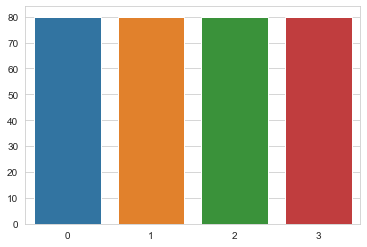

In [8]:
sns.barplot(df1['category'].value_counts().index, df_train['category'].value_counts().values)
plt.show()

## Normaliser les données
Choisir une méthode de normalisation, comparer les résultats obtenus avec différentes méthodes 

### Boite à outils

K-NN : https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html   
Robust Scaler : https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.RobustScaler.html   
StandardScaler : 
https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html#sklearn.preprocessing.StandardScaler         
MinMaxScaler : 
https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.MinMaxScaler.html#sklearn.preprocessing.MinMaxScaler      

In [9]:
imputer = KNNImputer(n_neighbors=2)
df1= pd.DataFrame(imputer.fit_transform(df1), columns=df1.columns)
df_test= pd.DataFrame(imputer.fit_transform(df_test), columns=df_test.columns)

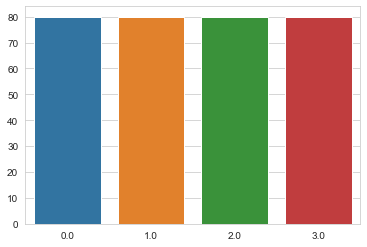

In [10]:
sns.barplot(df1['category'].value_counts().index, df1['category'].value_counts().values)
plt.show()

## Etudier l’opportunité d’une réduction de dimension
- Tester les perfs obtenus pour différentes valeurs
- Visualiser la variance expliquée par chaque axe
- Justifier le nombre d’axes retenus

### Boite à outils  
Analyse en composante principale : https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html   

In [11]:
df1.isna().sum().sum()
df1

,music_id,chroma_0_mean,chroma_0_std,chroma_10_mean,chroma_10_std,chroma_11_mean,chroma_11_std,chroma_1_mean,chroma_1_std,chroma_2_mean,...,mfcc_9_std,onset_rate,spectral_centroid_mean,spectral_decrease_mean,spectral_flux_mean,spectral_rolloff_mean,spectral_spread_mean,zcr_mean,zcr_std,category
0,0.0,866.507629,1585.437134,415.300842,710.790771,683.865845,1011.552856,473.484100,744.247925,304.914825,...,0.647313,3.631719,27.621587,-0.186330,1.962404,1525.877193,1579.021838,190.907164,149.482276,1.0
1,1.0,832.956909,2140.568115,287.584564,281.795380,405.467224,754.076904,1061.359863,2263.894531,2502.509033,...,0.575588,6.230564,38.780628,-0.013198,2.139456,1740.789474,1941.791036,257.913214,171.257592,3.0
2,2.0,331.544586,553.657532,260.467499,327.618225,283.580139,312.385986,204.369690,225.922531,286.470215,...,0.837297,4.264771,86.371120,-0.155013,1.336048,5243.859649,15422.032531,508.122337,296.141124,3.0
3,3.0,454.521851,1170.188110,601.021790,1035.021240,721.523865,1861.131836,350.991791,495.942383,432.551971,...,0.702976,4.064860,16.844325,-0.287745,2.207420,988.596491,999.051613,144.638374,142.303996,1.0
4,4.0,180.331635,245.818512,388.924744,917.082581,186.856262,192.765305,212.240402,370.108063,170.875610,...,0.487534,4.164816,5.764473,-0.626706,1.263404,21.491228,735.051431,181.818928,106.604597,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
315,315.0,201.047287,371.107574,299.208069,513.571228,202.888824,350.334076,136.945358,160.941696,122.406479,...,0.682789,4.231453,13.944149,-0.181232,0.868810,601.754386,708.050160,93.339311,36.764702,3.0
316,316.0,221.224380,544.881226,383.954285,692.860474,211.776245,391.426514,183.083939,356.709473,331.565094,...,0.676786,2.665482,22.796043,-0.173625,0.970722,1053.070175,795.352537,113.657963,90.647185,0.0
317,317.0,329.830750,476.118591,488.436249,558.929810,478.886597,710.991638,236.155884,456.825226,213.324387,...,0.538871,3.031986,13.298654,-0.255245,1.293797,494.298246,774.661745,135.595606,89.264260,1.0
318,318.0,449.190338,378.119537,456.445587,353.592621,444.994553,778.855469,652.472839,544.411926,869.565552,...,0.540750,7.696579,22.895394,0.015666,1.431960,623.245614,805.558346,163.264103,68.759594,1.0


In [12]:
pd.crosstab(df1['music_id'], df1['category'])

category,0.0,1.0,2.0,3.0
music_id,,,,
0.0,0,1,0,0
1.0,0,0,0,1
2.0,0,0,0,1
3.0,0,1,0,0
4.0,0,1,0,0
...,...,...,...,...
315.0,0,0,0,1
316.0,1,0,0,0
317.0,0,1,0,0


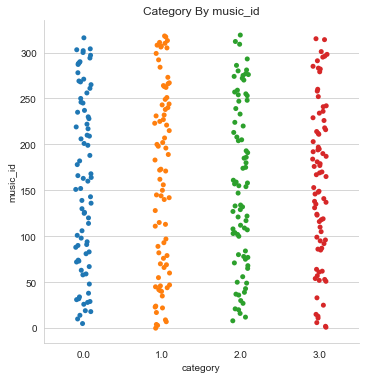

In [13]:
df1.groupby(['category']).mean()
sns.catplot(data=df1, x='category', y='music_id')
plt.title('Category By music_id')
plt.show()

## Créer un échantillon non biaisé de validation
A moins que vous n'utilisiez la k-fold validation (stratifiée ?)

### Boite à outil :   
`from sklearn.model_selection import train_test_split`  

In [14]:
from sklearn import svm
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
df1 = df1.drop(['category'],axis=1)

In [15]:
X_train, X_test, y_train, y_test = train_test_split(df1, y, test_size = 0.2, random_state=42)

In [16]:
lgb = LGBMClassifier(random_state=40,n_estimators=100,objective ='multiclass',num_leaves=31,num_class=3)
lgb.fit(X_train, y_train)
u=lgb.predict(X_test)

print("LGBM Classifier accuracy : " , accuracy_score(u, y_test))

neigh = KNeighborsClassifier(n_neighbors=3)
neigh.fit(X_train, y_train)
u=neigh.predict(X_test)
print("KNeighborsClassifier accuracy : " , accuracy_score(u, y_test))

rfc = RandomForestClassifier(max_depth=2, random_state=0)
rfc.fit(X_train, y_train)
u=rfc.predict(X_test)
print("RandomForestClassifier accuracy : " , accuracy_score(u, y_test))

clf = GradientBoostingClassifier(n_estimators=100, learning_rate=1.0,max_depth=1, random_state=0)
clf.fit(X_train, y_train)
u=clf.predict(X_test)
print("GradientBoostingClassifier accuracy : " , accuracy_score(u, y_test))

LR = LogisticRegression(random_state=0, solver='lbfgs', multi_class='ovr')
LR.fit(X_train, y_train)
u=LR.predict(X_test)
print("LogisticRegression accuracy : " , accuracy_score(u, y_test))

SVMLinear = svm.LinearSVC()
SVMLinear.fit(X_train, y_train)
u=SVMLinear.predict(X_test)
print("LinearSVC accuracy : " , accuracy_score(u, y_test))

SVC = svm.SVC()
SVC.fit(X_train, y_train)
u=SVC.predict(X_test)
print("SVC accuracy : " , accuracy_score(u, y_test))

LGBM Classifier accuracy :  0.75
KNeighborsClassifier accuracy :  0.515625
RandomForestClassifier accuracy :  0.609375
GradientBoostingClassifier accuracy :  0.734375
LogisticRegression accuracy :  0.53125
LinearSVC accuracy :  0.5
SVC accuracy :  0.484375


## Entrainer différents algorithmes de classification

`model = ...`   
`model.fit(X_train, y_train)`

### Boite à outils  
SVM : https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html   
Random Forest : https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier   
Regression logistique : https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html   

In [17]:
X_train, X_test, y_train, y_test = train_test_split(df1, y, test_size = 0.2, random_state=42)

In [18]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

## Comparer la performance de différents algorithmes
Faire des prédictions et evaluer leur justesse de ces prédictions à l'aide de différents indicateurs :
- Matrice de confusion
- Accuracy
- F-Score

### Boite à outils  
Un rapport de performance clé en main : https://scikit-learn.org/stable/modules/generated/sklearn.metrics.classification_report.html   

Liste des différents indicateurs : https://scikit-learn.org/stable/modules/model_evaluation.html

Faire une prédiction avec un model sklearn entrainé :
`y_pred_1 = model_1.predict(X_val, y_val)`   





In [19]:
lgb = LGBMClassifier(random_state=40,n_estimators=100,objective ='multiclass',num_leaves=31,num_class=3)
lgb.fit(X_train, y_train)
u=lgb.predict(X_test)

print("LGBM Classifier accuracy : " , accuracy_score(u, y_test))

neigh = KNeighborsClassifier(n_neighbors=3)
neigh.fit(X_train, y_train)
u=neigh.predict(X_test)
print("KNeighborsClassifier accuracy : " , accuracy_score(u, y_test))

rfc = RandomForestClassifier(max_depth=2, random_state=0)
rfc.fit(X_train, y_train)
u=rfc.predict(X_test)
print("RandomForestClassifier accuracy : " , accuracy_score(u, y_test))

clf = GradientBoostingClassifier(n_estimators=100, learning_rate=1.0,max_depth=1, random_state=0)
clf.fit(X_train, y_train)
u=clf.predict(X_test)
print("GradientBoostingClassifier accuracy : " , accuracy_score(u, y_test))

LR = LogisticRegression(random_state=0, solver='lbfgs', multi_class='ovr')
LR.fit(X_train, y_train)
u=LR.predict(X_test)
print("LogisticRegression accuracy : " , accuracy_score(u, y_test))

SVMLinear = svm.LinearSVC()
SVMLinear.fit(X_train, y_train)
u=SVMLinear.predict(X_test)
print("LinearSVC accuracy : " , accuracy_score(u, y_test))

SVC = svm.SVC()
SVC.fit(X_train, y_train)
u=SVC.predict(X_test)
print("SVC accuracy : " , accuracy_score(u, y_test))

LGBM Classifier accuracy :  0.734375
KNeighborsClassifier accuracy :  0.6875
RandomForestClassifier accuracy :  0.609375
GradientBoostingClassifier accuracy :  0.734375
LogisticRegression accuracy :  0.765625
LinearSVC accuracy :  0.78125
SVC accuracy :  0.75


In [20]:
X_test

array([[0.52351097, 0.49003522, 0.43620368, ..., 0.02294806, 0.19500192,
        0.2741814 ],
       [0.72100313, 0.99622783, 0.50229601, ..., 0.09378299, 0.68080476,
        0.39954503],
       [0.07836991, 0.85410888, 0.51454281, ..., 0.04340916, 0.35586458,
        0.16162981],
       ...,
       [0.46394984, 0.16066111, 0.12439117, ..., 0.13307249, 0.30041489,
        0.20129182],
       [0.96865204, 0.1322282 , 0.11423593, ..., 0.35849822, 0.44867102,
        0.32766347],
       [0.80877743, 0.41708478, 0.25713299, ..., 0.01077575, 0.11555767,
        0.07339021]])

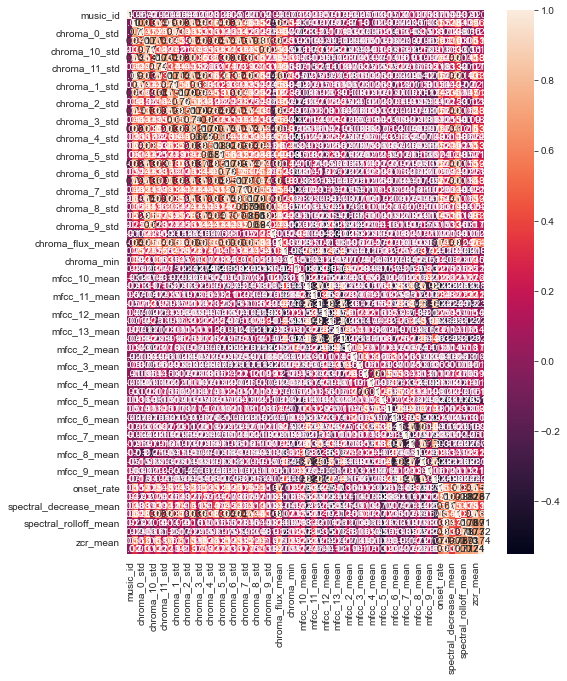

In [21]:
plt.figure(figsize=(8,10))
df1_corr = df1.corr().round(2)

sns.heatmap(df1_corr, annot=True)
plt.show()

## Optimiser les hyper-paramètres de l’algorithme retenu
Tester différents hyper-paramètres pour tirer au mieux partit de l'algorithme retenu

### Boite à outils  
GridSearchCV :  https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html



In [21]:
params_grid = [{'kernel': ['rbf'], 'gamma': [1e-3, 1e-4],
                     'C': [1, 10, 100, 1000]},
                    {'kernel': ['linear'], 'C': [1, 10, 100, 1000]}]

In [22]:
import numpy as np
import pylab as pl
import pandas as pd
import matplotlib.pyplot as plt 
%matplotlib inline
import seaborn as sns
from sklearn.utils import shuffle
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix,classification_report
from sklearn.model_selection import cross_val_score, GridSearchCV
# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

import os

In [23]:
svm_model = GridSearchCV(SVC(), params_grid, cv=5)
svm_model.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=SVC(),
             param_grid=[{'C': [1, 10, 100, 1000], 'gamma': [0.001, 0.0001],
                          'kernel': ['rbf']},
                         {'C': [1, 10, 100, 1000], 'kernel': ['linear']}])

In [24]:
# View the accuracy score
print('Best score for training data:', svm_model.best_score_,"\n") 

# View the best parameters for the model found using grid search
print('Best C:',svm_model.best_estimator_.C,"\n") 
print('Best Kernel:',svm_model.best_estimator_.kernel,"\n")
print('Best Gamma:',svm_model.best_estimator_.gamma,"\n")

final_model = svm_model.best_estimator_

Best score for training data: 0.8401960784313725 

Best C: 1000 

Best Kernel: rbf 

Best Gamma: 0.001 



In [25]:
final_model

SVC(C=1000, gamma=0.001)

## Prédire des valeurs pour le jeu de test 
Créer un fichier au format .csv contenant  vos prédictions.
En header le nom des colonnes (music_id et prediction) et pour chacun des morceaux la catégorie prédite.

Vérifier que votre notebook fonctionne avant de le rendre 

### Boite à outils  
exporter un dataFrame pandas au format csv :
`df_test.to_csv('data/test.csv' , sep=',', decimal='.')`

In [33]:
y_pred = lgb.predict_proba(df_test)
y_pred = [x[0] for x in y_pred]
solutions = pd.DataFrame(y_pred, columns=['prediction'])
solutions.to_csv('data/predict_lgb.csv',sep=',', decimal='.', index_label='music_id')

In [34]:
y_pred = neigh.predict_proba(df_test)
y_pred = [x[0] for x in y_pred]
solutions = pd.DataFrame(y_pred, columns=['prediction'])
solutions.to_csv('data/predict_neight.csv',sep=',', decimal='.', index_label='music_id')

In [35]:
y_pred = rfc.predict_proba(df_test)
y_pred = [x[0] for x in y_pred]
solutions = pd.DataFrame(y_pred, columns=['prediction'])
solutions.to_csv('data/predict_rfc.csv',sep=',', decimal='.', index_label='music_id')

In [36]:
y_pred = clf.predict_proba(df_test)
y_pred = [x[0] for x in y_pred]
solutions = pd.DataFrame(y_pred, columns=['prediction'])
solutions.to_csv('data/predict_clf.csv',sep=',', decimal='.', index_label='music_id')

In [37]:
y_pred = LR.predict_proba(df_test)
y_pred = [x[0] for x in y_pred]
solutions = pd.DataFrame(y_pred, columns=['prediction'])
solutions.to_csv('data/predict_lr.csv',sep=',', decimal='.', index_label='music_id')

In [38]:
y_pred = SVMLinear.predict_proba(df_test)
y_pred = [x[0] for x in y_pred]
solutions = pd.DataFrame(y_pred, columns=['prediction'])
solutions.to_csv('data/predict_svmL.csv',sep=',', decimal='.', index_label='music_id')

AttributeError: 'LinearSVC' object has no attribute 'predict_proba'

In [39]:
y_pred = SVC.predict_proba(df_test)
y_pred = [x[0] for x in y_pred]
solutions = pd.DataFrame(y_pred, columns=['prediction'])
solutions.to_csv('data/predict_svmSVC.csv',sep=',', decimal='.', index_label='music_id')

TypeError: 'property' object is not callable